# 🎓 Maestría en Inteligencia Artificial Aplicada

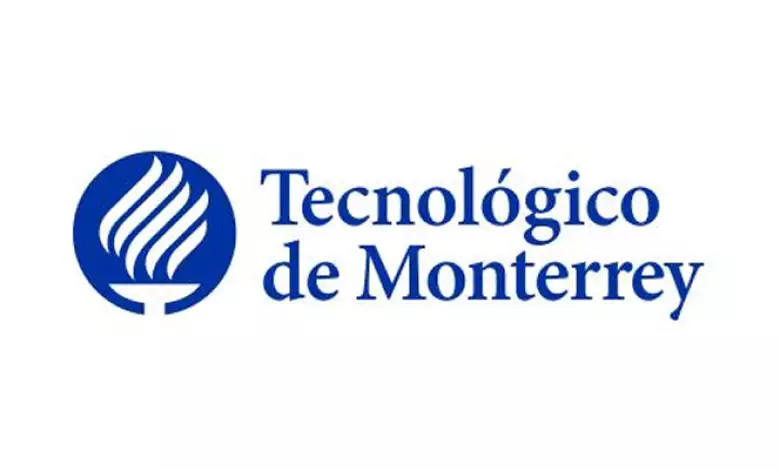

## 🖼️ **Proyecto Integrador**

### 👨‍🏫 **Profesores**

- **Profesor Titular:** Dra. Grettel Barceló Alonso
- **Asesor:** Dr. Horacio Martínez Alfaro

## **<font color="#895cf9">Avance 2. Ingeniería de características</font>**
### **Spin Compass**

### 📌 **Detalles de la Actividad**

- **Código:** 10.5 Google Colab
- **Título:** Avance 2. Ingeniería de características
- **Fecha de entrega:** 8 de feb de 2026 23:59
- **Formato de entrega:** Notebook (.ipynb) + Informe
- **Modalidad:** Equipo

## 👥 **Equipo 5**

### 🚀 **Nuestro Equipo**

  - Tania Alicia Caballero Saavedra - A01795957
  - Oscar Enrique García García - A01016093
  - Dante Rosas Fragoso – A01795850



In [1]:
!pip install sentence-transformers
!pip install PyMuPDF

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 63.0 MB/s eta 0:00:00


In [2]:
"""
Script de Chunking Semántico Avanzado
Integra lógica original de limpieza con nuevos algoritmos:
1. Max-Min Semantic Chunking
2. Growing Window Semantic Chunking
"""

import math
import os
import re
from pathlib import Path
from typing import List

import fitz  # PyMuPDF
import numpy as np
import pandas as pd
import tiktoken
from sentence_transformers import SentenceTransformer, util
from google.colab import drive

# --- 1. Configuración y Constantes ---

try:
    drive.mount("/content/drive")
    # Ruta específica del usuario original
    DRIVE_PATH = Path("/content/drive/MyDrive/Colab_Notebooks/MNA/Proyecto_Integrador-main")

    if DRIVE_PATH.exists():
        PROJECT_ROOT = DRIVE_PATH
        print(f"Ruta de Drive encontrada: {PROJECT_ROOT}")
    else:
        # Si la carpeta específica no existe en tu Drive, usamos una local
        print("La ruta específica no se encontró en Drive. Usando entorno local.")
        PROJECT_ROOT = Path("/content/proyecto_integrador")

except Exception as e:
    print(f"No se pudo montar Drive ({e}). Usando entorno local.")
    PROJECT_ROOT = Path("/content/proyecto_integrador")

# Definimos y creamos la ruta de datos raw si no existe
RAW_DATA_PATH = PROJECT_ROOT / "data" / "raw"
RAW_DATA_PATH.mkdir(parents=True, exist_ok=True)

print(f"Los archivos se buscarán en: {RAW_DATA_PATH}")
print("NOTA: Si no tienes los archivos ahí, súbelos manualmente a esa carpeta en el panel de la izquierda.")

# Configuración de Modelos
TOKENIZER_MODEL = "cl100k_base"  # Para conteo de tokens
EMBEDDING_MODEL_NAME = "paraphrase-multilingual-MiniLM-L12-v2"

# Inicialización de Modelos
encoder = tiktoken.get_encoding(TOKENIZER_MODEL)
print(f"Cargando modelo de embeddings: {EMBEDDING_MODEL_NAME}...")
embedding_model = SentenceTransformer(EMBEDDING_MODEL_NAME)




Mounted at /content/drive
La ruta específica no se encontró en Drive. Usando entorno local.
Los archivos se buscarán en: /content/proyecto_integrador/data/raw
NOTA: Si no tienes los archivos ahí, súbelos manualmente a esa carpeta en el panel de la izquierda.
Cargando modelo de embeddings: paraphrase-multilingual-MiniLM-L12-v2...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/526 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [6]:
# --- 2. Funciones de Carga y Limpieza ---

def extract_text_from_pdf(pdf_path: str) -> str:
    """Extrae todo el texto de un archivo PDF."""
    doc = fitz.open(pdf_path)
    text = ""
    for page in doc:
        text += page.get_text()
    return text


def load_documents(base_path: Path) -> pd.DataFrame:
    """
    Carga documentos PDF, TXT o MD desde una ruta base.
    Retorna un DataFrame con el nombre del archivo, ruta y texto crudo.
    """
    if not base_path.exists():
        print(f"Advertencia: La ruta {base_path} no existe. Creando ruta vacía.")
        base_path.mkdir(parents=True, exist_ok=True)
        return pd.DataFrame(columns=["file", "path", "text"])

    docs = []
    for path in base_path.rglob("*"):
        text = ""
        try:
            if path.suffix.lower() == ".pdf":
                text = extract_text_from_pdf(str(path))
            elif path.suffix.lower() in [".txt", ".md"]:
                text = path.read_text(encoding="utf-8", errors="ignore")
            else:
                continue

            if text.strip():  # Solo agregar si hay texto
                docs.append({
                    "file": path.name,
                    "path": str(path),
                    "text": text
                })
        except Exception as e:
            print(f"Error leyendo {path.name}: {e}")

    return pd.DataFrame(docs)


class NoiseReducer:
    """Clase encargada de limpiar ruido común en documentos corporativos."""

    def __init__(self):
        self.patterns = [
            r"page\s+\d+(\s+of\s+\d+)?",
            r"página\s+\d+(\s+de\s+\d+)?",
            r"instituto tecnológico.*",
            r"tecnológico de monterrey.*",
            r"este documento.*confidencial.*",
            r"Spin\s+HOJA\s+\d+\s+de\s+\d+",
            r"Código\s+ND-TIFS-PEC-\d+",
            r"Dirección Administración y Finanzas",
            r"Versión:\s+\d+\.\d+",
            r"Fecha de creación:.*",
            r"Fecha de modificación.*",
            r"Estatus\s+Vigente"
        ]

    def clean(self, text: str) -> str:
        """Aplica limpieza de patrones y normalización de espacios."""
        for p in self.patterns:
            text = re.sub(p, "", text, flags=re.IGNORECASE)

        # Normalización de saltos de línea
        text = re.sub(r"\n{3,}", "\n\n", text)
        text = re.sub(r"\n\s*\n", "\n\n", text)
        return text.strip()


def normalize_text(text: str) -> str:
    """Normalización final: colapsa espacios y une líneas rotas."""
    text = re.sub(r"\n{2,}", "\n\n", text)
    text = re.sub(r"(?<!\n)\n(?!\n)", " ", text)
    return text.strip()


def split_into_sentences(text: str) -> List[str]:
    """Divide el texto en oraciones usando puntuación básica."""
    sentences = re.split(r'(?<=[.!?])\s+', text)
    return [s.strip() for s in sentences if len(s.strip()) > 5]




# 2. Implementación de los Métodos

1: Max-Min Semantic Chunking
Basado en el documento Max–Min semantic chunking of documents for RAG application.pdf, este algoritmo decide si agrupar una oración basándose en la similitud mínima dentro del chunk actual y la similitud máxima de la nueva oración contra el chunk

2: Growing Window Semantic Chunking

Basado en el documento Optimising retrieval performance in RAG systems... .pdf, este método compara el embedding del chunk acumulado contra el embedding de las siguientes $m$ oraciones .

Parámetros:Para Max-Min, los autores recomiendan hard_thr=0.6, c=0.9, init_const=1.5.Para Growing Window, los autores probaron configuraciones como $n=6, m=3$ y $n=8, m=4$.

In [7]:
# --- 3. Nuevos Algoritmos de Chunking ---

def get_embeddings(sentences: List[str]):
    """Wrapper para obtener embeddings de una lista de textos."""
    return embedding_model.encode(sentences, convert_to_tensor=True)


def sigmoid(x: float) -> float:
    """Función sigmoide auxiliar."""
    return 1 / (1 + math.exp(-x))


def max_min_chunking(
    text: str,
    hard_thr: float = 0.6,
    c: float = 0.9,
    init_const: float = 1.5
) -> List[str]:
    """
    Implementación del algoritmo Max-Min Semantic Chunking.
    Referencia: Kiss et al. (2025)
    """
    sentences = split_into_sentences(text)
    if not sentences:
        return []

    embeddings = get_embeddings(sentences)
    chunks = []
    current_chunk_indices = []

    for k, embedding_k in enumerate(embeddings):
        # Inicialización del primer chunk
        if not current_chunk_indices:
            current_chunk_indices.append(k)
            continue

        # Caso: El chunk actual tiene solo una oración
        if len(current_chunk_indices) == 1:
            prev_idx = current_chunk_indices[0]
            sim = util.cos_sim(embeddings[prev_idx], embedding_k).item()

            if init_const * sim > hard_thr:
                current_chunk_indices.append(k)
            else:
                chunks.append(" ".join([sentences[i] for i in current_chunk_indices]))
                current_chunk_indices = [k]
            continue

        # Caso: Chunk con múltiples oraciones
        chunk_embeddings = embeddings[current_chunk_indices]

        # Calcular min_sim(C): mínima similitud dentro del chunk
        cos_scores = util.cos_sim(chunk_embeddings, chunk_embeddings)
        mask = ~np.eye(len(chunk_embeddings), dtype=bool)
        min_sim_c = cos_scores[mask].min().item() if mask.any() else 1.0

        # Calcular max_sim(sk, C): máxima similitud de nueva oración con chunk
        sims_new = util.cos_sim(embedding_k, chunk_embeddings)
        max_sim_sk_c = sims_new.max().item()

        # Threshold dinámico
        thr_c = max(c * min_sim_c * sigmoid(len(current_chunk_indices)), hard_thr)

        if max_sim_sk_c >= thr_c:
            current_chunk_indices.append(k)
        else:
            chunks.append(" ".join([sentences[i] for i in current_chunk_indices]))
            current_chunk_indices = [k]

    # Agregar remanente
    if current_chunk_indices:
        chunks.append(" ".join([sentences[i] for i in current_chunk_indices]))

    return chunks


def growing_window_chunking(
    text: str,
    n: int = 6,
    m: int = 3,
    threshold: float = 0.5
) -> List[str]:
    """
    Implementación del algoritmo Growing Window Semantic Chunking.
    Referencia: Moreno-Cediel et al. (2025)
    """
    sentences = split_into_sentences(text)
    if not sentences:
        return []

    chunks = []
    i = 0
    total_sentences = len(sentences)

    # Inicializar con las primeras 'n' oraciones
    current_chunk_sents = sentences[i:min(i + n, total_sentences)]
    i += len(current_chunk_sents)

    while i < total_sentences:
        # Obtener las siguientes 'm' oraciones candidatas
        next_m_sents = sentences[i:min(i + m, total_sentences)]
        if not next_m_sents:
            break

        # Comparar embedding del chunk acumulado vs. embedding de las siguientes m
        emb_current = get_embeddings([" ".join(current_chunk_sents)])[0]
        emb_next = get_embeddings([" ".join(next_m_sents)])[0]

        similarity = util.cos_sim(emb_current, emb_next).item()

        if similarity >= threshold:
            # Unir (Crecer ventana)
            current_chunk_sents.extend(next_m_sents)
            i += len(next_m_sents)
        else:
            # Cortar y reiniciar con las siguientes 'n'
            chunks.append(" ".join(current_chunk_sents))
            current_chunk_sents = sentences[i:min(i + n, total_sentences)]
            i += len(current_chunk_sents)

    if current_chunk_sents:
        chunks.append(" ".join(current_chunk_sents))

    return chunks




In [8]:
# --- 4. Pipeline Principal de Ejecución ---

def main():
    # A. Cargar Documentos
    print(">>> Cargando documentos...")
    df_docs = load_documents(RAW_DATA_PATH)

    if df_docs.empty:
        print("No se encontraron documentos. Por favor sube archivos a:", RAW_DATA_PATH)
        return

    # B. Limpieza
    print(">>> Limpiando texto...")
    reducer = NoiseReducer()
    df_docs["clean_text"] = df_docs["text"].apply(reducer.clean)
    df_docs["clean_text"] = df_docs["clean_text"].apply(normalize_text)

    # C. Aplicar Métodos de Chunking
    print(">>> Ejecutando Max-Min Semantic Chunking...")
    # Parámetros recomendados: hard_thr=0.6, c=0.9, init_const=1.5
    df_docs["max_min_chunks"] = df_docs["clean_text"].apply(
        lambda x: max_min_chunking(x, hard_thr=0.6, c=0.9, init_const=1.5)
    )

    print(">>> Ejecutando Growing Window Semantic Chunking...")
    # Parámetros recomendados: n=6, m=3 (o n=8, m=4)
    df_docs["growing_window_chunks"] = df_docs["clean_text"].apply(
        lambda x: growing_window_chunking(x, n=6, m=3, threshold=0.5)
    )

    # D. Resultados y Comparación
    print("\n>>> Generando reporte de resultados...")

    # Preparar DataFrames para visualización
    df_maxmin = df_docs.explode("max_min_chunks")[["file", "max_min_chunks"]]
    df_maxmin["method"] = "Max-Min"
    df_maxmin.rename(columns={"max_min_chunks": "chunk_content"}, inplace=True)

    df_growing = df_docs.explode("growing_window_chunks")[["file", "growing_window_chunks"]]
    df_growing["method"] = "Growing Window"
    df_growing.rename(columns={"growing_window_chunks": "chunk_content"}, inplace=True)

    # Concatenar y calcular métricas
    df_final = pd.concat([df_maxmin, df_growing])
    df_final["token_count"] = df_final["chunk_content"].apply(
        lambda x: len(encoder.encode(str(x))) if pd.notna(x) else 0
    )

    # Mostrar estadísticas
    stats = df_final.groupby("method")["token_count"].describe()
    print("\nEstadísticas de Tokens por Método:")
    print(stats)

    print("\nEjemplo de los primeros chunks:")
    print(df_final.head())

# Guardar MinMax en su propio CSV
    df_maxmin.to_csv("resultados_minmax.csv", index=False)
    print("\nArchivo 'resultados_minmax.csv' guardado con éxito.")

    # Guardar Growing Window en su propio CSV
    df_growing.to_csv("resultados_growingwindow.csv", index=False)
    print("Archivo 'resultados_growingwindow.csv' guardado con éxito.")


if __name__ == "__main__":
    main()

>>> Cargando documentos...
>>> Limpiando texto...
>>> Ejecutando Max-Min Semantic Chunking...
>>> Ejecutando Growing Window Semantic Chunking...

>>> Generando reporte de resultados...

Estadísticas de Tokens por Método:
                count        mean         std    min     25%    50%     75%  \
method                                                                        
Growing Window   21.0  622.857143  875.933747  143.0  285.00  387.0  647.00   
Max-Min         168.0   77.452381   58.134864    5.0   33.75   68.5  106.25   

                   max  
method                  
Growing Window  4336.0  
Max-Min          412.0  

Ejemplo de los primeros chunks:
                         file  \
0  politica-gastos-viajes.pdf   
0  politica-gastos-viajes.pdf   
0  politica-gastos-viajes.pdf   
0  politica-gastos-viajes.pdf   
0  politica-gastos-viajes.pdf   

                                       chunk_content   method  token_count  
0  Nomenclatura  Spin_POL_AYF_GA V_02  Política G... 

# Interpretación de resultados para Max-Min Semantic Chunking

El archivo resultados_minmax.csv contiene los segmentos de texto (chunks) generados por el algoritmo Max-Min Semantic Chunking.

Interpretaciones, basándonos en las primeras filas cargadas:

1. Estructura de las Columnas
file: Indica el documento de origen (ej. politica-gastos-viajes.pdf). Es útil para rastrear de dónde vino la información.

chunk_content: Es el resultado principal. Muestra el texto que el algoritmo decidió agrupar. La longitud y el contenido de este texto varían dinámicamente según lo que el algoritmo consideró "semánticamente coherente".

method: Confirma que se usó la técnica "Max-Min".

2. Interpretación de los Resultados (Ejemplos Reales)
Analizando las primeras 5 filas del archivo, se observa cómo "piensa" el algoritmo:

Identificación de Estructuras Repetitivas (Filas 0 y 2):

Los chunks que comienzan con "Nomenclatura Spin_POL..." y terminan con el aviso de "información INTERNA" son encabezados o pies de página que se repiten en el documento original.

Interpretación: El algoritmo detectó que este bloque de texto tiene una coherencia interna fuerte y lo separó del resto.

Observación: Al aparecer idéntico en las filas 0 y 2, sugiere que el pre-procesamiento de limpieza podría mejorarse para eliminar encabezados de página repetitivos antes de aplicar el chunking, ya que estos pueden generar ruido en las búsquedas (RAG).

Agrupación de Tablas y Metadatos (Fila 1):

Este chunk agrupa toda la sección de "Autorizaciones" e "Historial de versiones".

Interpretación: A pesar de ser varias líneas distintas, el algoritmo determinó que todas hablan del mismo tema (control administrativo del documento) y las mantuvo juntas en un solo bloque grande. Esto es correcto semánticamente.

Separación de Reglas Específicas (Filas 3 y 4):

Fila 3: "1.4 17/06/2024 ... 9.10 Todas las reservaciones deberán realizarse 14 días antes."

Fila 4: "9.11 Todas las solicitudes deberán ser aprobadas por el Jefe Directo."

Interpretación: Aquí el algoritmo muestra su fortaleza. En lugar de mezclar estas reglas en un párrafo gigante, detectó que la regla 9.10 y la 9.11 son ideas distintas y creó chunks pequeños y precisos para cada una.

Valor para RAG: Esto es ideal. Si un usuario pregunta "¿Con cuánto tiempo debo reservar?", el sistema recuperará solo la Fila 3, dando una respuesta precisa sin información irrelevante.

# Interpretación de resultados para Growing Window Semantic Chunking
El archivo resultados_growingwindow.csv contiene los segmentos de texto (chunks) generados por el algoritmo Growing Window Semantic Chunking.

Interpretaciones, basándonos en las primeras filas cargadas:

1. Estructura de las Columnas
file: Indica el documento de origen (ej. politica-gastos-viajes.pdf). Es útil para rastrear de dónde vino la información.

chunk_content: Es el resultado principal. Muestra el texto que el algoritmo decidió agrupar en una "ventana" continua. A diferencia del método anterior, aquí la longitud tiende a ser mucho mayor porque el algoritmo busca mantener el contexto unido mientras la similitud semántica sea alta.

method: Confirma que se usó la técnica "Growing Window".

2. Interpretación de los Resultados (Ejemplos Reales)
Analizando las primeras filas del archivo, se observa cómo "piensa" este algoritmo (enfoque acumulativo):

Fusión de Estructuras Repetitivas y Metadatos (Fila 0):

El primer chunk es un bloque masivo (aprox. 2,450 caracteres) que incluye el encabezado inicial, el aviso de confidencialidad, la repetición idéntica de estos elementos en la segunda página, la sección de autorizaciones y el historial de versiones.

Interpretación: El algoritmo funciona comparando la ventana actual con la siguiente oración. Al encontrar un encabezado repetido (texto idéntico), la similitud semántica fue máxima, por lo que el algoritmo determinó que "el tema continúa" y decidió no cortar, fusionando múltiples páginas de metadatos en un solo bloque.

Observación: Esto confirma que Growing Window es muy sensible al "ruido" documental. Sin una limpieza previa que elimine encabezados y pies de página, el algoritmo tiende a generar bloques excesivamente largos que mezclan contenido real con repeticiones estructurales.

Agrupación de Índices y Listas (Fila 1):

Este chunk agrupa prácticamente todo el índice del documento ("1. OBJETIVO... 5.6 Hospedaje").

Interpretación: El algoritmo identificó que todas las líneas del índice comparten una estructura semántica y gramatical similar (frases cortas nominales). Por tanto, las trató como una unidad cohesiva.

Valor para RAG: Esto es útil para preguntas de resumen general (ej. "¿Qué temas aborda este documento?"), pero menos efectivo para encontrar una sección específica rápidamente.

Fusión de Reglas Específicas (Incrustadas en la Fila 0):

Dentro del bloque gigante de la Fila 0, se encuentran mezcladas las reglas críticas: "9.10 Todas las reservaciones deberán realizarse 14 días antes" y "9.11 Todas las solicitudes deberán ser aprobadas...".

Interpretación: A diferencia de Max-Min, que separó estas reglas quirúrgicamente, Growing Window las "enterró" dentro de un contexto amplio de metadatos. El algoritmo priorizó la continuidad del texto sobre la distinción de ideas individuales.

Valor para RAG: Esto presenta un desafío para la precisión. Si un usuario pregunta "¿Cuándo debo reservar?", el sistema recuperará este bloque enorme lleno de avisos legales y firmas, obligando al modelo de lenguaje a leer mucho texto irrelevante para encontrar la respuesta de una sola línea.

3. Pistas Visuales de Saturación (Cómo identificar "Mega-Chunks")
Al inspeccionar el archivo CSV (ya sea en Excel o en texto plano), existen señales visuales claras que confirman que el algoritmo generó bloques saturados de información:

La Ilusión de la Celda Vacía (en Excel): Si la celda de contenido (ej. B2) parece estar vacía o en blanco, no significa falta de datos.

Causa: El algoritmo absorbió los saltos de línea (\n) del documento original. Excel muestra solo la primera línea visible; si el texto comienza con espacios o saltos, la celda parecerá vacía aunque contenga miles de caracteres ocultos debajo.

La Trampa de las Comillas (en Texto Plano): Al ver el archivo como texto crudo, el bloque comienza con una comilla de apertura (") y no se cierra hasta pasar múltiples páginas de texto.

Interpretación: El formato CSV encierra en comillas cualquier texto que contenga saltos de línea internos. Si las comillas no se cierran rápidamente, indica que todo ese volumen de texto pertenece a una única fila lógica que no fue segmentada.

El Efecto "Déjà Vu" (Repetición Interna): Al leer el contenido de un solo chunk, se encuentran frases idénticas repetidas (como el encabezado "Nomenclatura Spin...") sin que haya una nueva fila de datos.

Conclusión: Esta repetición interna es la prueba definitiva de que el algoritmo fusionó la Página 1 y la Página 2 en el mismo bloque, ignorando los límites físicos del documento debido a su alta similitud semántica.